In [1]:
import numpy as np
import pandas as pd
import pickle, os
import spacy
import fasttext

from tqdm.auto import tqdm, trange
from scipy.spatial.distance import cosine

from utils import embedding, get_embedding, text_cleaning, find_top_n , tfidf_sentences

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Preprocessing

In [3]:
# Loading spacy nlp model
nlp = spacy.load("en_core_web_sm")

In [4]:
# Getting the titles from file names
title_list = []

for file in os.listdir("Local pdf text files"):
  if file.endswith(".txt"):
    title_list.append(file.split(".")[0])

In [5]:
# Getting the text from local text files
pdf_list = []
    
for file in os.listdir("Local pdf text files"):
  if file.endswith(".txt"):
    with open("Local pdf text files/"+file,"r",encoding="utf8") as f:
        pdf_list.append(f.read())

In [6]:
# cleaning text and titles
pdfs = list(map(lambda x: text_cleaning(x,nlp), pdf_list))
titles = list(map(lambda x: text_cleaning(x,nlp), title_list))

# lemmatization
pdfs = list(map(lambda x: ' '.join([token.lemma_ for token in x]), pdfs))
titles = list(map(lambda x: ' '.join([token.lemma_ for token in x]), titles))

# removing PRON after lemmatization
pdfs = list(map(lambda x: x.replace("-PRON-",""), pdfs))
titles = list(map(lambda x: x.replace("-PRON-",""), titles))

In [7]:
# Tfidf for abstracts
vec_abs = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1, 2))
vec_abs.fit(pdfs)

# Tfidf for titles
vec_title = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1, 2))
vec_title.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=100,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [8]:
#np.array(vec_abs.get_feature_names())

In [9]:
# # np.array(vec_abs.get_feature_names())
# arr1 = X[0].toarray()
# arr2 = X[1].toarray()

In [10]:
# 1-cosine(cer,arr2)

In [11]:
# cer = "A ceramic is a solid material comprising an inorganic compound of metal or metalloid and non-metal with ionic or covalent bonds. Common examples are earthenware, porcelain, and brick."
# y = vec_abs.transform([cer])

In [12]:
# cer = y.toarray()

### Model Installation

In [13]:
# path = "crawl-300d-2M.vec"

# with open('training_data.txt','w',encoding="utf-8") as f:
#       f.write('\n'.join(pdfs))

# train_data = 'training_data.txt'

# ft_model = fasttext.train_unsupervised(input=train_data, pretrainedVectors=path, dim=300)

In [14]:
# Saving the model
#ft_model.save_model("ft_model.bin")

# Loading the model
ft_model = fasttext.load_model("ft_model.bin")

### Labels

In [15]:
# Creating sentences for each document with the strongest tfidf words

tfidf_words_abstract = []

for abstract in tqdm(pdfs):
    tfidf_words_abstract.append(" ".join(find_top_n(abstract,vec_abs,20)))
    
tfidf_words_title = []

for title in tqdm(titles):
    tfidf_words_title.append(" ".join(find_top_n(title,vec_title,10)))

In [16]:
tfidf_words_abstract[:5]

['base sample printing ceramic sinter shape print density produce method surface strength study property use process formation fabricate fdm fiber',
 'glass size different layer temperature material shape porosity increase sample melt printing stress print surface powder property use process high',
 'ceramic printing component present technique material performance research shape energy metal make print application fabrication high fabricate property use process',
 'fiber reinforce composite print fabrication base use printing value deposition model tensile strength fused deposition fused improve deposition technique method tensile model mechanical property',
 'glass material base manufacturing product printing research energy print application manufacture method additive manufacturing additive use process composite increase build fused']

In [17]:
tfidf_words_title[:5]

['zirconia printing ceramic manufacture lattice structure experimental manufacturing fabricate fabricate selective fabrication',
 'surface printing glass print process property fiber evaluation evolution experimental',
 'review print ceramic zirconia fused experimental fabricate fabricate selective fabrication fdm',
 'continuous fiber composite print zirconia evaluation experimental fabricate fabricate selective fabrication',
 'glass print zirconia fused evolution experimental fabricate fabricate selective fabrication fdm']

In [18]:
list(filter(lambda x:len(x.split())==2,list(np.array(vec_abs.get_feature_names()))))

['additive manufacturing',
 'deposition model',
 'fused deposition',
 'lattice structure',
 'mechanical property',
 'process parameter',
 'selective laser',
 'slm process',
 'tensile strength']

In [19]:
production_1 = ft_model.get_sentence_vector('selective laser melting')
production_2 = ft_model.get_sentence_vector('direct metal laser sintering')

production_3 = ft_model.get_sentence_vector('fused deposition modeling')
production_4 = ft_model.get_sentence_vector('fused filament fabrication')
production_5 = ft_model.get_sentence_vector('extrusion based additive manufacturing')

metal = ft_model.get_sentence_vector('metal')
ceramic = ft_model.get_sentence_vector('ceramic')
polymer = ft_model.get_sentence_vector('polymer')

# feature_1 = get_embedding('fracture toughness')
# feature_2 = get_embedding('tensile strength')
# feature_3 = get_embedding('yield strength')
# feature_4 = get_embedding('elastic modulus')
# feature_5 = get_embedding('strain fracture break')
# feature_6 = get_embedding('weibull modulus')

In [20]:
def pro_labeling(doc):
    
    production = []
    production_cos_score = []
    
    for text in doc:
        
        text = ft_model.get_sentence_vector(text)
        
        lbl= []

        lbl.append(1-cosine(text,production_1))
        lbl.append(1-cosine(text,production_2))
        lbl.append(1-cosine(text,production_3))
        lbl.append(1-cosine(text,production_4))
        lbl.append(1-cosine(text,production_5))

        if lbl.index(max(lbl))==0 or lbl.index(max(lbl))==1:
            production.append('SLM or DMLS')
            production_cos_score.append(max(lbl))
        else:
            production.append('FDM or FFF or EAM')
            production_cos_score.append(max(lbl))
    
    return production , production_cos_score

In [21]:
def mat_labeling(doc):

    material = []  
    material_cos_score = []

    for text in doc:
        
        text = ft_model.get_sentence_vector(text)
        
        lbl= []

        lbl.append(1-cosine(text,metal))
        lbl.append(1-cosine(text,ceramic))
        lbl.append(1-cosine(text,polymer))

        if lbl.index(max(lbl))==0:
            material.append('Metal')
            material_cos_score.append(max(lbl))
        elif lbl.index(max(lbl))==1:
            material.append('Ceramic')
            material_cos_score.append(max(lbl))
        else:
            material.append('Polymer')
            material_cos_score.append(max(lbl))
    
    return material , material_cos_score

In [22]:
def create_df_abs():
    
    d_abs = {'Titles':title_list,
         'Abstracts':pdf_list,
         'Abs_Production':abs_production,
         'Abs_Production_score':abs_production_cos_score,
         'Abs_Material':abs_material,
         'Abs_Material_score':abs_material_cos_score
        }
    
    df = pd.DataFrame(d_abs)
    #df["Production/Material"] = df["Abs_Production"] + " / " + df["Abs_Material"]
    
    return df

In [23]:
def create_df_title():
    
    d_title = {'Titles':title_list,
         'Abstracts':pdf_list,
         'Title_Production':title_production,
         'Title_Production_score':title_production_cos_score,
         'Title_Material':title_material,
         'Title_Material_score':title_material_cos_score
        }
    
    df = pd.DataFrame(d_title)
    #df["Production/Material"] = df["Title_Production"] + " / " + df["Title_Material"]
    
    return df

### Labeling with abstracts and Titles

In [24]:
abs_production , abs_production_cos_score = pro_labeling(tfidf_words_abstract)
abs_material , abs_material_cos_score = mat_labeling(tfidf_words_abstract)
df_abs = create_df_abs()

title_production , title_production_cos_score = pro_labeling(tfidf_words_title)
title_material , title_material_cos_score = mat_labeling(tfidf_words_title)
df_title = create_df_title()

In [25]:
pdf_list[3]

'We have developed a method for the three-dimensional (3D) printing of continuous fiber-reinforced thermoplastics based on fused-deposition modeling. The technique enables direct 3D fabrication without the use of molds and may become the standard next-generation composite fabrication methodology. A thermoplastic filament and continuous fibers were separately supplied to the 3D printer and the fibers were impregnated with the filament within the heated nozzle of the printer immediately before printing. Polylactic acid was used as the matrix while carbon fibers, or twisted yarns of natural jute fibers, were used as the reinforcements. The thermoplastics reinforced with unidirectional jute fibers were examples of plant-sourced composites; those reinforced with unidirectional carbon fiber showed mechanical properties superior to those of both the jute-reinforced and unreinforced thermoplastics. Continuous fiber reinforcement improved the tensile strength of the printed composites relative 

In [26]:
pdfs[3]

' have develop a method for the three dimensional printing of continuous fiber reinforce thermoplastic base on fused deposition model the technique enable direct fabrication without the use of mold and may become the standard next generation composite fabrication methodology a thermoplastic filament and continuous fiber be separately supply to the printer and the fiber be impregnate with the filament within the heated nozzle of the printer immediately before print polylactic acid be use as the matrix while carbon fiber or twist yarn of natural jute fiber be use as the reinforcement the thermoplastic reinforce with unidirectional jute fiber be example of plant source composite those reinforce with unidirectional carbon fiber show mechanical property superior to those of both the jute reinforce and unreinforced thermoplastic continuous fiber reinforcement improve the tensile strength of the print composite relative to the value show by conventional print polymer base composites'

In [27]:
df_abs["Abs_Production"].value_counts()

FDM or FFF or EAM    71
SLM or DMLS          28
Name: Abs_Production, dtype: int64

In [28]:
df_title["Title_Production"].value_counts()

FDM or FFF or EAM    68
SLM or DMLS          31
Name: Title_Production, dtype: int64

In [29]:
df_abs["Abs_Material"].value_counts()

Ceramic    73
Metal      20
Polymer     6
Name: Abs_Material, dtype: int64

In [30]:
df_title["Title_Material"].value_counts()

Ceramic    56
Metal      29
Polymer    14
Name: Title_Material, dtype: int64

In [31]:
df_abs.head()

,Titles,Abstracts,Abs_Production,Abs_Production_score,Abs_Material,Abs_Material_score
0,3D gel-printing of zirconia ceramic parts,3D gel-printing (3DGP) is a new printing metho...,FDM or FFF or EAM,0.881961,Ceramic,0.751230
1,3D Printed Glass Surface Finish and Bulk Prope...,It is impossible to print glass directly from ...,FDM or FFF or EAM,0.861991,Ceramic,0.713428
2,3D printing of ceramics A review,Along with extensive research on the three-dim...,FDM or FFF or EAM,0.883376,Ceramic,0.756373
3,3D Printing of Continuous-Fiber Composites by ...,We have developed a method for the three-dimen...,FDM or FFF or EAM,0.905677,Polymer,0.715738
4,3D Printing of Transparent Glass,Traditional assembly line manufacturing is spe...,FDM or FFF or EAM,0.939048,Ceramic,0.719551


In [32]:
df_title.head()

,Titles,Abstracts,Title_Production,Title_Production_score,Title_Material,Title_Material_score
0,3D gel-printing of zirconia ceramic parts,3D gel-printing (3DGP) is a new printing metho...,FDM or FFF or EAM,0.892678,Ceramic,0.769095
1,3D Printed Glass Surface Finish and Bulk Prope...,It is impossible to print glass directly from ...,FDM or FFF or EAM,0.864877,Ceramic,0.711444
2,3D printing of ceramics A review,Along with extensive research on the three-dim...,FDM or FFF or EAM,0.898858,Ceramic,0.778722
3,3D Printing of Continuous-Fiber Composites by ...,We have developed a method for the three-dimen...,FDM or FFF or EAM,0.880182,Polymer,0.717929
4,3D Printing of Transparent Glass,Traditional assembly line manufacturing is spe...,FDM or FFF or EAM,0.900735,Ceramic,0.726451


In [46]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X= []

for text in tfidf_words_title:
    X.append(ft_model.get_sentence_vector(text))

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

pca_df = pd.DataFrame(index=title_list,columns=['First Component','Second Component'],data=X_reduced)
pca_df["Labels"] = df_title["Title_Material"].values

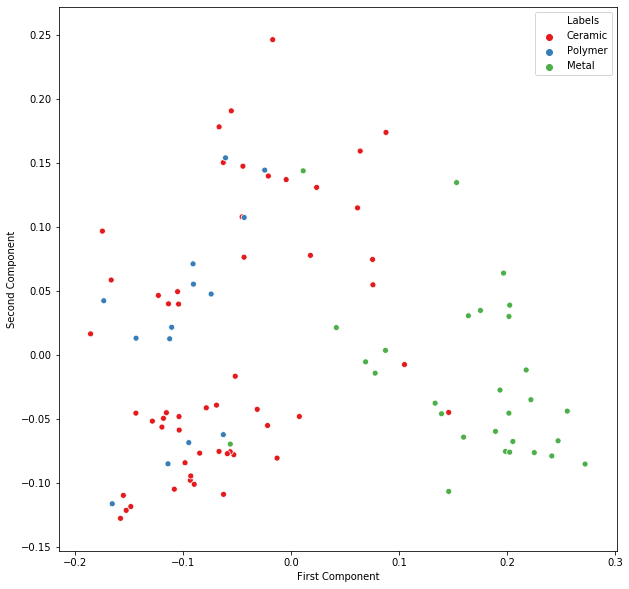

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')

In [35]:
# def vis_docs(abs_n,title_n,doc_type): # Tuple , number, number, list
    
#     # Tfidf for abstracts
#     vec_abs = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1,2))
#     vec_abs.fit(pdfs)

#     # Tfidf for titles
#     vec_title = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english',max_features=100,ngram_range=(1,2))
#     vec_title.fit(titles)
    
#     tfidf_words_abstract = []

#     for abstract in pdfs:
#         tfidf_words_abstract.append(" ".join(find_top_n(abstract,vec_abs,abs_n)))

#     tfidf_words_title = []

#     for title in titles:
#         tfidf_words_title.append(" ".join(find_top_n(title,vec_title,title_n)))
        
#     abs_production , abs_production_cos_score = pro_labeling(tfidf_words_abstract)
#     abs_material , abs_material_cos_score = mat_labeling(tfidf_words_abstract)
#     df_abs = create_df_abs()

#     title_production , title_production_cos_score = pro_labeling(tfidf_words_title)
#     title_material , title_material_cos_score = mat_labeling(tfidf_words_title)
#     df_title = create_df_title()
    
#     X= []

#     for text in doc_type:
#         X.append(ft_model.get_sentence_vector(text))

#     pca = PCA(n_components=2)
#     X_reduced = pca.fit_transform(X)

#     pca_df = pd.DataFrame(index=title_list,columns=['First Component','Second Component'],data=X_reduced)
#     pca_df["Labels"] = df_title["Title_Material"].values
    
#     fig, ax = plt.subplots(figsize=(10,10))
#     ax = sns.scatterplot(x=pca_df['First Component'],y=pca_df['Second Component'],hue=pca_df['Labels'],palette ='Set1')
    
#     return df_abs , df_title 

In [36]:
# df_abs , df_title = vis_docs(abs_n=20,title_n=10,doc_type=tfidf_words_abstract)

In [37]:
# df_2 = df_2.drop('que',axis=1)

In [38]:
# def que(x):
#     if x['Material_title'] == x['Material_abstract']:
#         return True
#     else:
#         return False
    
# df_2['que'] = df_2.apply(que, axis=1)

In [39]:
# df_2['que'].apply(lambda x:"x['que']" ,if x =="Ceramic",axis=1)

In [40]:
# sum(df_2['que'])

In [41]:
# df_2 = df_2[['Titles','Abstracts','Material_abstract','Material_abstract_score','Material_title','Material_title_score','que']]

In [42]:
# df_2 = df_2.drop(['que'],axis=1)

In [43]:
# df_2.to_excel("recent_results.xlsx")

In [44]:
# def r(x):
#     return round(x,2)

# df_2["Material_title_score"] = df_2["Material_title_score"].apply(lambda x:round(x,2))
# df_2["Production_title_score"] = df_2["Production_title_score"].apply(lambda x:round(x,2))

In [45]:
# temizlemeden bakilabilri aynimi diye
# yuksek olan abs ve titledan birseltirielbilir
# tfidf word sayilariyla oynanabilir

# https://www.datacamp.com/community/tutorials/stemming-lemmatization-python